# About Cancer

| **Feature**             | **Pituitary Tumor**                          | **Glioma**                                             | **Meningioma**                                         |
|-------------------------|----------------------------------------------|--------------------------------------------------------|--------------------------------------------------------|
| **Origin**              | Pituitary gland (base of brain)              | Glial cells (supporting brain cells)                   | Meninges (membranes covering brain/spinal cord)        |
| **Location**            | Sella turcica (central base of brain)        | Anywhere in brain or spinal cord                       | Outer surface of brain or spinal cord                  |
| **Common Types**        | Adenomas, prolactinomas, GH-secreting        | Astrocytoma, glioblastoma, oligodendroglioma           | Meningioma (benign, atypical, or malignant)            |
| **Benign or Malignant** | Usually benign                               | Can be benign or malignant (e.g., glioblastoma)        | Mostly benign, some atypical or malignant              |
| **Symptoms**            | Hormonal imbalance, vision problems          | Seizures, headaches, neurological deficits             | Headaches, seizures, focal neurological issues         |
| **Hormonal Effects**    | Yes (affects pituitary hormone levels)       | No                                                     | No                                                     |
| **Diagnosis Tools**     | MRI, hormone tests, visual field testing     | MRI, biopsy                                            | MRI, CT, biopsy                                        |
| **Treatment Options**   | Surgery (transsphenoidal), medication, radiation | Surgery, radiation, chemotherapy                    | Surgery, radiation if necessary                        |
| **Growth Rate**         | Usually slow-growing                         | Varies: slow (low-grade) to fast (e.g., glioblastoma)  | Typically slow-growing                                |
| **Age Group Affected**  | Adults (30s–60s)                              | All ages, depending on type                            | Adults (more common in women)                          |


| **Tumor Type**  | **Common Location(s)**                   | **Key Notes** |
|----------------|-------------------------------------------|---------------|
| **Pituitary**  | Base of brain (sella turcica)             | Under optic chiasm; midline structure; can affect vision and hormones |
| **Glioma**     | Anywhere in brain or spinal cord          | Often in cerebral hemispheres, brainstem; infiltrates brain tissue |
| **Meningioma** | Outer surface of brain, dura-based        | Arises from meninges; compresses but doesn't invade brain tissue |


https://www.mayoclinic.org/diseases-conditions/pituitary-tumors/symptoms-causes/syc-20350548#dialogId29480819

https://www.mayoclinic.org/diseases-conditions/glioma/symptoms-causes/syc-20350251

https://www.mayoclinic.org/diseases-conditions/meningioma/symptoms-causes/syc-20355643

# Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import time
from tqdm import tqdm
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

from collections import Counter

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline

import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import AdamW
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchsummary import summary
from torch.utils.data import random_split

torch.manual_seed(42)
random.seed(42)


# Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize the image
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    # normalizing using ImageNet 1k parameters
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# importing dataset
#dataset = ImageFolder('/content/drive/MyDrive/subset', transform=transform) # 100 per class
dataset = ImageFolder('/content/drive/MyDrive/data', transform=transform)

print(len(dataset))
print(dataset.classes)

# loading in dataloader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
image_tensor, label = dataset[0]
print(image_tensor.shape)
print(label)

6066
['brain_glioma', 'brain_menin', 'brain_tumor']
torch.Size([3, 224, 224])
0


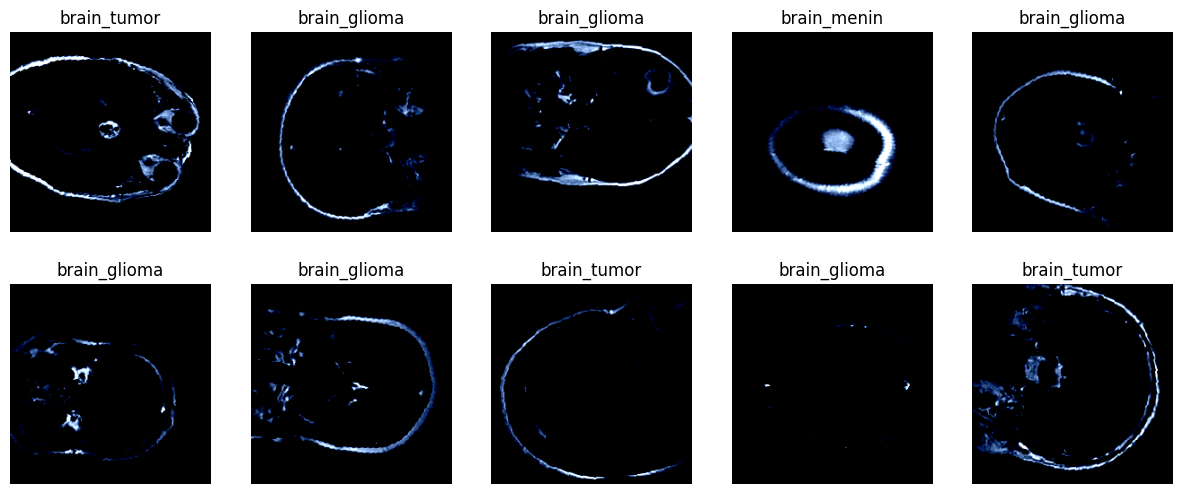

In [ ]:
# checking dataload
random_indices = random.sample(range(len(dataset)), 10)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    img, label = dataset[idx]
    img = img.permute(1, 2, 0)
    img = img.numpy()

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(dataset.classes[label])
    plt.axis('off')

In [ ]:
labels = np.array(dataset.targets)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_indices, test_indices = next(sss.split(np.zeros(len(labels)), labels))

train_labels = labels[train_val_indices]
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_indices, valid_indices = next(sss_val.split(np.zeros(len(train_val_indices)), train_labels))

train_indices = train_val_indices[train_indices]
valid_indices = train_val_indices[valid_indices]

train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)
test_dataset  = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

print("train dataset:", len(train_dataset))
print("valid dataset:", len(valid_dataset))
print("test dataset:", len(test_dataset))


Shape of images: torch.Size([64, 3, 224, 224])
Shape of labels: torch.Size([64])
train dataset: 4245
valid dataset: 607
test dataset: 1214


In [ ]:
labels = np.array(dataset.targets)

print("Train distribution:", Counter(labels[train_indices]))
print("Valid distribution:", Counter(labels[valid_indices]))
print("Test distribution:",  Counter(labels[test_indices]))

Train distribution: Counter({np.int64(2): 1433, np.int64(0): 1409, np.int64(1): 1403})
Valid distribution: Counter({np.int64(2): 205, np.int64(0): 202, np.int64(1): 200})
Test distribution: Counter({np.int64(2): 410, np.int64(0): 403, np.int64(1): 401})


# Pick Model

Let's break down the `timm` model name `tf_efficientnetv2_m.in21k_ft_in1k`:

*   **`tf_`**: TensorFlow and then converted for use in PyTorch.
*   **`efficientnetv2_m`**: This is the base model architecture. It refers to EfficientNetV2, specifically the 'M' (medium) variant. EfficientNetV2 is an improved version of the original EfficientNet, designed for better training speed and parameter efficiency.
*   **`.in21k`**: pre-trained on. "in21k" refers to ImageNet-21k
*   **`_ft_in1k`**: This indicates that the model was *fine-tuned* (`ft`) on the ImageNet-1k dataset (`in1k`).

resnet50.a1_in1k: ResNet-50 is a widely used and well-understood architecture. It provides a solid baseline for comparison and is generally less computationally expensive than larger ResNet models. The .a1_in1k suffix indicates it was trained on ImageNet-1k.

In [ ]:
# selecting timm model

# main model
# model_name = "tf_efficientnetv2_b0.in1k"

# comparison models
model_name = "resnet50.a1_in1k"
# model_name = "tf_efficientnet_b0.in1k"

# Model Training

## Initialize

In [ ]:
#torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def initialize_model(model_name, num_classes, feature_extract=True):

    # Use timm.create_model to load a ResNet model
    # You can choose a specific ResNet model name from timm's list, e.g., 'resnet18'
    #model = timm.create_model('resnet18', pretrained=True)

    model = timm.create_model(model_name, pretrained=True)

    # freezing the parameters of pretrained model
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

    # Modify the classifier layer
    # timm models might have different classifier attribute names (e.g., 'fc', 'head')
    # You'll need to check the specific model's structure
    # For resnet18 in timm, it's still 'fc'

    if hasattr(model, 'classifier'):
      # converting resnet output of 1000 classes
      # to 3 class output
      model.classifier = nn.Sequential(
          # y = Ax + b
          # converting x inputs to desired outputs
          nn.Linear(model.classifier.in_features, 512),
          # non linearity
          nn.ReLU(),
          # randomly deactivates neurons
          # reduce overfitting
          nn.Dropout(0.1),
          nn.Linear(512, num_classes)
          )
      classifier_layer_name = "classifier"

    elif hasattr(model, 'head'):
      classifier_layer = model.head
      classifier_layer_name = "head"

    elif hasattr(model, 'fc'):
      # converting resnet output of 1000 classes
      # to 3 class output
      model.fc = nn.Sequential(
          # y = Ax + b
          # converting x inputs to desired outputs
          nn.Linear(model.fc.in_features, 512),
          # non linearity
          nn.ReLU(),
          # randomly deactivates neurons
          # reduce overfitting
          nn.Dropout(0.1),
          nn.Linear(512, num_classes)
          )
      classifier_layer_name = "fc"

    #print(model.fc.in_features)

    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():

            # Assuming the new layers are in the 'fc' module
            if name.startswith(classifier_layer_name):
                params_to_update.append(param)
                param.requires_grad = True
    else:
        params_to_update = model.parameters()

    return model, params_to_update

## Training Parameters

In [ ]:
num_classes = len(dataset.classes)

model, params_to_update = initialize_model(
                          model_name,
                          num_classes,
                          feature_extract=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

num_epochs = 20
optimizer = AdamW(params_to_update, lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

cuda


## Save Model

In [ ]:
name = "tf_efficientnet_b0.in1k_20epochs_fulldataset"
checkpoint_path = f'/content/drive/MyDrive/models/{name}.pth'

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
          Identity-9         [-1, 32, 112, 112]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
    SqueezeExcite-14         [-1, 32, 1

## Training Setup

In [ ]:
def train_and_evaluate(train_loader, valid_loader, model, optimizer, criterion,
                      num_epochs, checkpoint_path):
    best_valid_loss = float('inf')
    device = next(model.parameters()).device

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0

        # loading taining data in batches
        for images, labels in tqdm(train_loader, desc=f'Train {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            # settting the gradients to zero for every batch
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(images)

            # computing cross-entropy loss and its gradients
            loss = criterion(outputs, labels)
            # backpropagation
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        ### MODEL Evaluation and SELECTION
        # Set the model to evaluation mode
        model.eval()
        valid_loss, valid_correct = 0, 0

        with torch.no_grad(): # Disable gradient computation and reduce memory consumption
            for images, labels in tqdm(valid_loader, desc=f'Valid {epoch+1}/{num_epochs}'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                valid_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        train_acc = 100 * train_correct / len(train_loader.dataset)
        valid_acc = 100 * valid_correct / len(valid_loader.dataset)

        # saving the model with best valid loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': valid_loss,
                'accuracy': valid_acc
            }, checkpoint_path)

        # decreading the learning rate by 10% every 3 epoch
        if epoch > 0 and epoch % 3 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.9

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train: {train_loss:.4f} ({train_acc:.2f}%) | "
              f"Val: {valid_loss:.4f} ({valid_acc:.2f}%) | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, best_valid_loss

## Training Loop

In [ ]:
start_time = time.time()

# training loop
model, best_valid_loss = train_and_evaluate(
    train_loader, valid_loader, model, optimizer,
    criterion, num_epochs=num_epochs,
    checkpoint_path=checkpoint_path # saving the model
)

executing_time = time.time() - start_time
print(f"Training time: {executing_time:.2f} seconds")

Valid 1/20: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch 1/20 | Train: 0.5503 (86.76%) | Val: 0.5021 (89.62%) | LR: 1.00e-03


Valid 2/20: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch 2/20 | Train: 0.4753 (91.10%) | Val: 0.4789 (91.76%) | LR: 1.00e-03


Valid 3/20: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch 3/20 | Train: 0.4504 (92.41%) | Val: 0.4445 (93.41%) | LR: 1.00e-03


Valid 4/20: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch 4/20 | Train: 0.4410 (93.10%) | Val: 0.4214 (94.73%) | LR: 9.00e-04


Valid 5/20: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch 5/20 | Train: 0.4178 (94.44%) | Val: 0.4258 (93.41%) | LR: 9.00e-04


Valid 6/20: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch 6/20 | Train: 0.4161 (94.58%) | Val: 0.4213 (94.07%) | LR: 9.00e-04


Valid 7/20: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 7/20 | Train: 0.4143 (94.61%) | Val: 0.4140 (94.56%) | LR: 8.10e-04


Valid 8/20: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch 8/20 | Train: 0.4007 (95.50%) | Val: 0.4223 (94.56%) | LR: 8.10e-04


Valid 9/20: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch 9/20 | Train: 0.3949 (96.04%) | Val: 0.3963 (95.55%) | LR: 8.10e-04


Valid 10/20: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch 10/20 | Train: 0.3911 (96.21%) | Val: 0.3969 (95.39%) | LR: 7.29e-04


Valid 11/20: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch 11/20 | Train: 0.3895 (96.18%) | Val: 0.4049 (94.23%) | LR: 7.29e-04


Valid 12/20: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch 12/20 | Train: 0.3800 (96.54%) | Val: 0.4011 (95.06%) | LR: 7.29e-04


Valid 13/20: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch 13/20 | Train: 0.3765 (97.22%) | Val: 0.3835 (96.54%) | LR: 6.56e-04


Valid 14/20: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch 14/20 | Train: 0.3745 (97.08%) | Val: 0.3831 (96.38%) | LR: 6.56e-04


Valid 15/20: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch 15/20 | Train: 0.3782 (96.73%) | Val: 0.3783 (96.71%) | LR: 6.56e-04


Valid 16/20: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch 16/20 | Train: 0.3698 (97.29%) | Val: 0.3741 (96.38%) | LR: 5.90e-04


Valid 17/20: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 17/20 | Train: 0.3711 (97.29%) | Val: 0.3717 (97.53%) | LR: 5.90e-04


Valid 18/20: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 18/20 | Train: 0.3708 (97.36%) | Val: 0.3779 (96.87%) | LR: 5.90e-04


Valid 19/20: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 19/20 | Train: 0.3651 (97.48%) | Val: 0.3680 (97.69%) | LR: 5.31e-04


Valid 20/20: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Epoch 20/20 | Train: 0.3597 (97.97%) | Val: 0.3809 (96.54%) | LR: 5.31e-04
Training time: 917.62 seconds


# Load Model

In [ ]:
# Load the saved model weights
model = timm.create_model(model_name, pretrained=False)

num_classes = len(dataset.classes)

# Add the modified classifier layers to the model
if hasattr(model, 'classifier'):
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
elif hasattr(model, 'head'):
    # Assuming 'head' is the classifier for this model
    # You might need to adjust this based on the specific model architecture
    model.head = nn.Sequential(
        nn.Linear(model.head.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
elif hasattr(model, 'fc'):
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
else:
    raise AttributeError("Model does not have a recognizable classifier layer (fc, head, or classifier)")

#print(model)

In [ ]:
model_name

'resnet50.a1_in1k'

In [ ]:
#name = "tf_efficientnet_b0.in1k_20epochs_fulldataset"
name = "resnet50.a1_in1k_20epochs_fulldataset"
#name = "tf_efficientnetv2_b0.in1k_20epochs_fulldataset"

checkpoint_path = f'/content/drive/MyDrive/models/{name}.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
checkpoint["epoch"]

16

# Testing

## Prediction

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluating'):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Evaluating: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]


| Metric     | Formula                                       | Purpose / Interpretation                                                                 |
|------------|-----------------------------------------------|-------------------------------------------------------------------------------------------|
| Precision  | TP / (TP + FP)                                | Of all predicted positives, how many were correct?                                        |
| Recall     | TP / (TP + FN)                                | Of all actual positives, how many were correctly predicted?                               |
| F1 Score   | 2 * (Precision * Recall) / (Precision + Recall) | Harmonic mean of precision and recall — balances both                                     |
| Accuracy   | (TP + TN) / (TP + TN + FP + FN)               | Overall correctness — how often the model is right                                       |


## Report

[[116 261  26]
 [  1 398   2]
 [  9 360  41]]


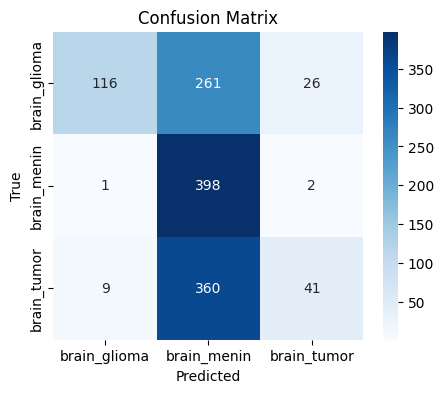

Test Accuracy: 0.4572
Classification Report:
              precision    recall  f1-score   support

brain_glioma       0.92      0.29      0.44       403
 brain_menin       0.39      0.99      0.56       401
 brain_tumor       0.59      0.10      0.17       410

    accuracy                           0.46      1214
   macro avg       0.64      0.46      0.39      1214
weighted avg       0.64      0.46      0.39      1214



In [ ]:
if hasattr(test_loader.dataset, 'dataset') and hasattr(test_loader.dataset.dataset, 'classes'):
    class_names = test_loader.dataset.dataset.classes
elif hasattr(test_loader.dataset, 'classes'):
    class_names = test_loader.dataset.classes
else:
    class_names = [str(i) for i in range(len(np.unique(all_labels)))]

cm = confusion_matrix(y_true=all_labels, y_pred=all_preds)

print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy = np.trace(cm) / np.sum(cm)
print(f'Test Accuracy: {accuracy:.4f}')
print('Classification Report:')
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

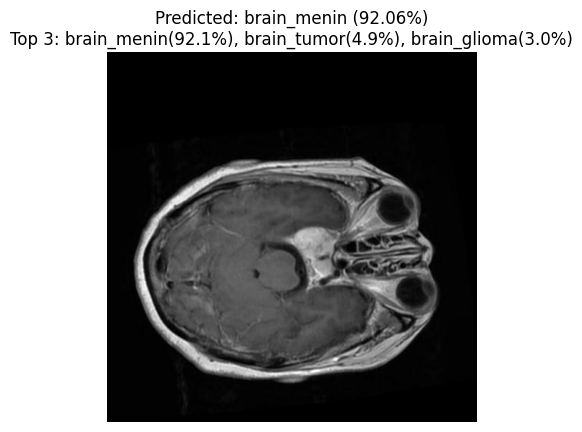


Predicted class: brain_menin
Confidence: 92.06%

Top 3 predictions:
1. brain_menin: 92.06%
2. brain_tumor: 4.89%
3. brain_glioma: 3.04%


In [ ]:
#import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

if hasattr(test_loader.dataset, 'dataset') and hasattr(test_loader.dataset.dataset, 'classes'):
    class_names = test_loader.dataset.dataset.classes
elif hasattr(test_loader.dataset, 'classes'):
    class_names = test_loader.dataset.classes
else:
    raise ValueError("Could not find class names in the dataset")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, model, class_names):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_idx = torch.max(output, 1)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0] * 100

    predicted_class = class_names[predicted_idx.item()]
    confidence = probabilities[predicted_idx.item()].item()


    top3_probs, top3_idxs = torch.topk(probabilities, 3)
    top3_classes = [(class_names[i], top3_probs[j].item())
                   for j, i in enumerate(top3_idxs)]

    return predicted_class, confidence, top3_classes

image_path = "/content/drive/MyDrive/test/brain_menin_0123.jpg"
pred_class, confidence, top3 = predict_image(image_path, model, class_names)

img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Predicted: {pred_class} ({confidence:.2f}%)\n"
          f"Top 3: {', '.join([f'{c[0]}({c[1]:.1f}%)' for c in top3])}")
plt.axis('off')
plt.show()

print(f"\nPredicted class: {pred_class}")
print(f"Confidence: {confidence:.2f}%")
print("\nTop 3 predictions:")
for i, (cls, prob) in enumerate(top3, 1):
    print(f"{i}. {cls}: {prob:.2f}%")

# Outputs and Rough Work

In [ ]:
 random.sample(range(len(dataset)), 10)

[101, 8, 130, 276, 151, 133, 184, 160, 293, 234]

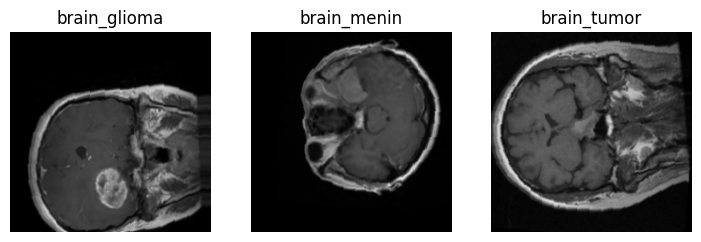

In [ ]:
#random_indices = random.sample(range(len(dataset)), 10)
random_indices = [1, 150, 250]
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    img, label = dataset[idx]
    img = img.permute(1, 2, 0)
    img = img.numpy()

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(dataset.classes[label])
    plt.axis('off')

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm